# Dataset
https://huggingface.co/datasets/mystic-leung/medical_cord19

# Install Required Libraries

In [ ]:
!pip install transformers datasets torch pandas matplotlib


In [ ]:
!nvidia-smi

Tue Dec  3 02:39:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install datasets -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install evaluate -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install rouge_score -q


  Preparing metadata (setup.py) ... done


# Import Libraries

In [ ]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load Pre-trained BART Model and Tokenizer

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "MohamedZaitoon/bart-fine-tune"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_bart = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

# Define Helper Functions for Data Processing and Evaluation

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [ ]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="input",
                               column_summary="output"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

# Load and Prepare the Dataset


Link: https://huggingface.co/datasets/mystic-leung/medical_cord19

In [ ]:
from datasets import load_dataset

dataset_name = "mystic-leung/medical_cord19"

data= load_dataset(dataset_name,split='train')
num_samples = 500
dataset_samsum = data.select(range(num_samples)).train_test_split( test_size=0.2)


print(f"Features: {dataset_samsum['train'].column_names}")


README.md:   0%|          | 0.00/194 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/331M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/70.8M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/70.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/210000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/45000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/45000 [00:00<?, ? examples/s]

Features: ['input', 'output']


# Inspect a sample input from the test set

In [ ]:
dataset_samsum['test'][1]['input']

'BACKGROUND: Extensive sequencing efforts have been taking place for the Atlantic cod (Gadus morhua) in recent years, the number of ESTs in the Genbank has reached more than 140.000. Despite its importance in North Atlantic fisheries and potential use in aquaculture, relatively few gene expression examination exists for this species, and systematic evaluations of reference gene stability in quantitative real-time RT-PCR (qRT-PCR) studies are lacking. RESULTS: The stability of 10 potential reference genes was examined in six tissues of Atlantic cod obtained from four populations, to determine the most suitable genes to be used in qRT-PCR analyses. Relative transcription levels of genes encoding β-actin (ACTB), elongation factor 1A (EF1A), actin-related protein-2 (ARP-2), glyceraldehyde-3P-dehydrogenase (GAPDH), ubiquitin (Ubi), acidic ribosomal protein (ARP), ribosomal protein S9 (S9), ribosomal protein L4 (RPL4), RPL22 and RPL37 were quantified in gills, brain, liver, head kidney, musc

# Generate and Print a Summary Using the Pipeline

In [ ]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_samsum['test'][1]['input'] )

print(pipe_out)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'summary_text': 'The stability of 10 potential reference genes was examined in six tissues of Atlantic cod obtained from four populations .\nThe number of ESTs in the Genbank has reached more than 140.000 .\nDespite its importance in North Atlantic fisheries and potential use in aquaculture, relatively few gene expression examination exists .'}]


In [ ]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

The stability of 10 potential reference genes was examined in six tissues of Atlantic cod obtained from four populations .
The number of ESTs in the Genbank has reached more than 140.000 .
Despite its importance in North Atlantic fisheries and potential use in aquaculture, relatively few gene expression examination exists .


# Load ROUGE Metric

In [ ]:
import evaluate
rouge_metric = evaluate.load('rouge')

# Define and Calculate ROUGE Metrics

In [ ]:
import evaluate


rouge_metric = evaluate.load('rouge')

def calculate_metric_on_test_ds(test_dataset, metric, model, tokenizer, column_text, column_summary, batch_size=8):
    predictions = []
    references = []

    for i in range(0, len(test_dataset), batch_size):
        batch = test_dataset[i:i+batch_size]

        inputs = tokenizer(batch[column_text], return_tensors="pt", padding=True, truncation=True).to(model.device)

        outputs = model.generate(inputs.input_ids)
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        predictions.extend(decoded_preds)
        references.extend(batch[column_summary])

    results = metric.compute(predictions=predictions, references=references)
    return results

score = calculate_metric_on_test_ds(
    dataset_samsum['test'],
    rouge_metric,
    model_bart,
    tokenizer,
    column_text='input',
    column_summary='output',
    batch_size=8
)

print("ROUGE Score:", score)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


ROUGE Score: {'rouge1': 0.23909066609719315, 'rouge2': 0.09128658326042569, 'rougeL': 0.2051393226222531, 'rougeLsum': 0.20451404074439372}


# Display ROUGE Scores

In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_dict = dict((rn, score[rn]) for rn in rouge_names)

rouge_df = pd.DataFrame(rouge_dict, index=['bart'])

print(rouge_df)



        rouge1    rouge2    rougeL  rougeLsum
bart  0.239091  0.091287  0.205139   0.204514


# Plot Token Length Distributions

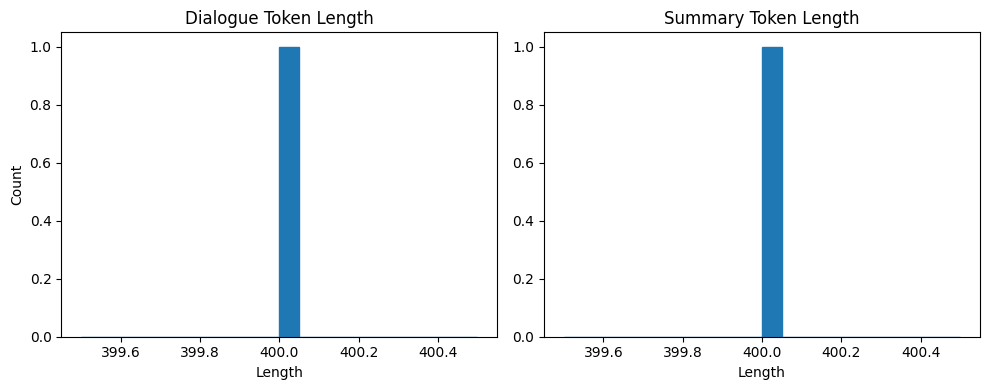

In [ ]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['input']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['output']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

# Prepare the Dataset for Training

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['input'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['output'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# Set Up Data Collator for Sequence-to-Sequence Tasks

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_bart)

# Configure Training Arguments

In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='bart-samsum',
    num_train_epochs=3,
    warmup_steps=300,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    logging_steps=50,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    gradient_accumulation_steps=8,
    save_total_limit=2,
    load_best_model_at_end=True,
    greater_is_better=True,
    learning_rate=5e-5,
    report_to="none"
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Initialize the Trainer

In [ ]:
trainer = Trainer(model=model_bart, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["test"])

<ipython-input-36-7bf4aef01576>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model_bart, args=trainer_args,


# Train the Model

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,2.192122
2,2.309200,2.101762
3,2.309200,2.070949


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=75, training_loss=2.206095733642578, metrics={'train_runtime': 475.934, 'train_samples_per_second': 2.521, 'train_steps_per_second': 0.158, 'total_flos': 946656472645632.0, 'train_loss': 2.206095733642578, 'epoch': 3.0})

# Re-evaluate the Fine-tuned Model on the Test Set

In [ ]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'input', column_summary= 'output'
)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)

rouge_df = pd.DataFrame(rouge_dict, index=[f'bart'])

print(rouge_df)

        rouge1    rouge2    rougeL  rougeLsum
bart  0.307451  0.148789  0.260546   0.259868


# Save the Fine-tuned Model and Tokenizer

In [ ]:
model_bart.save_pretrained("MohamedZaitoon/bart-fine-tune")

In [ ]:
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Test the Fine-tuned Model on a Sample Input

In [ ]:
sample_text = dataset_samsum["test"][0]["input"]

reference = dataset_samsum["test"][0]["output"]

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="MohamedZaitoon/bart-fine-tune",tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
The article discusses the first-year results of Ukraine's NAQA work -- the agency, whose activity is aimed at ensuring higher education quality The results of the accreditation evaluation of the educational programs of Ukrainian universities are presented More than 60% of the programs have been accredited, about 34% received conditional accreditation with the possibility to rectify the noted shortcomings within 1 year, and in more than 2% of cases HEIs have been refused in accreditation The most changes in the accreditation process because of coronavirus pandemic began in March 2020 It was decided to use the provisional accreditation procedures using information technology tools and videoconferencing to respond to COVID-19 quarantine challenges The current situation forces interview with stakeholders, discussions within the expert group, meetings with HEIs and NAQAs representatives to be done using videoconferencing and other IT tools (distance format) Given the uncertain sit